# Question 8

In [289]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [290]:
eagle_path = os.path.join(".", "imgs", "rsz_eagle.jpg")
ori_eagle = plt.imread(eagle_path)
eagle = ori_eagle/255  # Normalize the value
# panda_path = os.path.join(".", "imgs", "rsz_eagle.jpg")
# panda = plt.imread(eagle_path)
imgs = np.reshape(eagle, [-1, 299, 299, 3])

In [291]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [292]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
                                X, num_classes=1001, is_training=False)
    predictions = end_points["Predictions"]
    saver = tf.train.Saver()

In [293]:
ckpt_path = os.path.join(".", "temp", "inception_v3", "inception_v3.ckpt")
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    pred, logi = sess.run([predictions, logits], feed_dict={X:imgs})
print(pred)
print(logi)

INFO:tensorflow:Restoring parameters from ./temp/inception_v3/inception_v3.ckpt
[[3.5401343e-05 5.0831954e-05 4.0685889e-05 ... 1.9077404e-05
  4.7846610e-05 3.5531968e-05]]
[[-1.3913161e-01  2.2264339e-01  8.9406967e-08 ... -7.5737643e-01
   1.6211924e-01 -1.3544802e-01]]


In [294]:
classes_path = os.path.join("..", "datasets", "inception", "imagenet_class_names.txt")
classes = list(open(classes_path))

In [295]:
for line in range(len(classes)):
    classes[line] = classes[line][10: -1]

In [296]:
i = 0
print("Predicted top-5 classes are:")
for ind, sco in sorted(enumerate(logi[0]), reverse=True, key=lambda x: x[1]):
#     print(ind, sco)
    if i > 20:
        break
    print("        %s with score %.2f and index of %d" % (classes[ind], sco, ind))
    i += 1

Predicted top-5 classes are:
        vulture with score 10.06 and index of 23
        bald eagle, American eagle, Haliaeetus leucocephalus with score 4.24 and index of 22
        grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus with score 2.82 and index of 147
        drake with score 2.37 and index of 97
        stage with score 2.32 and index of 819
        tusker with score 2.03 and index of 101
        ptarmigan with score 2.03 and index of 81
        black stork, Ciconia nigra with score 2.01 and index of 128
        spoonbill with score 1.89 and index of 129
        kite with score 1.88 and index of 21
        organ, pipe organ with score 1.72 and index of 687
        valley, vale with score 1.71 and index of 979
        broccoli with score 1.64 and index of 937
        black swan, Cygnus atratus with score 1.59 and index of 100
        king penguin, Aptenodytes patagonica with score 1.56 and index of 145
        Bedlington terrier with score 1.48 a

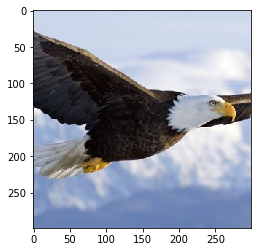

In [297]:
plt.imshow(imgs[0])
plt.show()

# Question 9

In [298]:
import sys
import tarfile
import urllib

In [369]:
import re
from PIL import Image, ImageChops, ImageOps
import pandas

def fetch_file_from_url(url, path, filename):
    full_file_path = os.path.join(path, filename)
    if os.path.isfile(full_file_path):
        return
    if not os.path.isdir(path):
        os.makedirs(path)
    urllib.request.urlretrieve(url, filename=full_file_path)

def extract_and_delete_tarfile(path, filename):
    full_file_path = os.path.join(path, filename)
    file_tgz = tarfile.open(full_file_path)
    file_tgz.extractall(path=path)
    file_tgz.close()
    os.remove(full_file_path)
    
def extract_class_names(path, filename, pattern="n\d+\s(\w+(.*\w+)*)\\n"):
    pattern = re.compile(pattern)
    full_file_path = os.path.join(path, filename)
    with open(full_file_path) as file:
        classes = list(file)
    for ind in range(len(classes)):
        print(classes[ind])
        classes[ind] = re.search(pattern, classes[ind]).group(1)
        print(classes[ind])
    return classes

def rsz_img(path, size=299):
    im = Image.open(path)
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image
    # thumbnail is a in-place operation
    # im.thumbnail(new_size, Image.ANTIALIAS)
    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it
    new_im = Image.new("RGB", (size, size))
    new_im.paste(im, ((size-new_size[0])//2,
                        (size-new_size[1])//2))
    new_im = np.array(new_im)
    return new_im
    
def preprocess_jpg_by_path(base_path, rsz_func=rsz_img, ninstance=None):
    i, j, X, y = 0, 0, [], []
    name_pattern = re.compile(".*/(w+)")
    for path in os.listdir(base_path):
        full_path = os.path.join(base_path, path)
        if not os.path.isdir(full_path):
            continue
        name = path
        for file in os.listdir(full_path):
            if i >= ninstance:
                break
            if file.endswith(".jpg"):
                img = 2 * rsz_func(os.path.join(full_path, file)) / 255 -1
#                 print(img.shape)
                X.append(img)
                y.append(name)
                i += 1
        i = 0
#     X = np.concatenate(X, axis=len(X[0].shape))
    X = np.stack(X, axis=0)
#     y = np.concatenate(y, axis=len(y[0].shape))
    y = np.stack(y, axis=0)
    return X, y
                
def onehot_encode_label(labels, nclass=False):
    label_dict = {}
    lst_classes = np.unique(labels)
    num_classes = len(lst_classes)
    onehot_labels = []
    for i in range(num_classes):
#         encoding = np.zeros([num_classes])
#         encoding[i] = 1
        encoding = i
        label_dict[lst_classes[i]] = encoding
    for label in labels:
        onehot_labels.append(label_dict[label])
    onehot_labels = np.stack(onehot_labels)
    if nclass:
        return onehot_labels, num_classes
    return onehot_labels

In [367]:
base_img_path = os.path.join(".", "imgs", "flower_photos")
feedX, feedy = preprocess_jpg_by_path(base_img_path, ninstance=500)

In [370]:
feedy, nclass = onehot_encode_label(feedy, True)

In [371]:
shuffle_ind = np.random.randint(feedy.shape[0], size=[feedy.shape[0]])
feedX = feedX[shuffle_ind]
feedy = feedy[shuffle_ind]
split_ind1 = int(0.7 * feedX.shape[0])
split_ind2 = int(0.9 * feedX.shape[0])
X_train = feedX[:split_ind1]
y_train = feedy[:split_ind1]
X_valid = feedX[split_ind1:split_ind2]
y_valid = feedy[split_ind1:split_ind2]
X_test = feedX[split_ind2:]
y_test = feedy[split_ind2:]

In [372]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
                                X, num_classes=1001, is_training=False)
    predictions = end_points["Predictions"]
    saver = tf.train.Saver()

In [373]:
kersize = 1
y = tf.placeholder(dtype=tf.int32, shape=[None])
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])
new_logits = tf.layers.dense(prelogits, nclass, name="new_logits")
vars_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
new_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
new_loss = tf.reduce_mean(new_xentropy)
new_optimizer = tf.train.AdamOptimizer()
new_training_op = new_optimizer.minimize(new_loss,var_list=vars_list)
new_initializer = tf.global_variables_initializer()

In [374]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [375]:
def get_mini_batch(X, y, batch_size, epoch, batch):
    """
    get a batch of training set
    """
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

In [ ]:
num_train = X_train.shape[0]
batch_size = 100
n_epoch = 20
n_batch = int(np.ceil(num_train/batch_size))

with tf.Session() as sess:
    sess.run(new_initializer)
    saver.restore(sess, ckpt_path)
    for epoch in range(1, n_epoch+1):
        for batch in range(1, n_batch+1):
            X_batch, y_batch = get_mini_batch(X_train, y_train, batch_size, epoch, batch)
            sess.run([new_training_op], feed_dict={X:X_batch, y:y_batch})
        valid_acc, valid_loss = sess.run([accuracy, new_loss], feed_dict={X:X_valid, y:y_valid})
        train_acc, train_loss = sess.run([accuracy, new_loss], feed_dict={X:X_batch, y:y_batch})
        print("epoch:")
        print("        valid_acc={}, valid_loss={}".format(valid_acc, valid_loss))
        print("        train_acc={}, train_loss={}".format(train_acc, train_loss))
        

INFO:tensorflow:Restoring parameters from ./temp/inception_v3/inception_v3.ckpt
epoch:
        valid_acc=0.6819999814033508, valid_loss=0.9909176230430603
        train_acc=0.699999988079071, train_loss=0.9188228845596313
epoch:
        valid_acc=0.7599999904632568, valid_loss=0.7556639909744263
        train_acc=0.7699999809265137, train_loss=0.7013585567474365
epoch:
        valid_acc=0.7599999904632568, valid_loss=0.6965269446372986
        train_acc=0.8399999737739563, train_loss=0.7217665314674377
epoch:
        valid_acc=0.828000009059906, valid_loss=0.6213418245315552
        train_acc=0.8600000143051147, train_loss=0.45599982142448425
epoch:
        valid_acc=0.8159999847412109, valid_loss=0.6080906391143799
        train_acc=0.8899999856948853, train_loss=0.41991305351257324
epoch:
        valid_acc=0.8360000252723694, valid_loss=0.5741997361183167
        train_acc=0.8799999952316284, train_loss=0.5031177997589111
epoch:
        valid_acc=0.8220000267028809, valid_loss=0.5479